# Attribution Maps Workflow
This notebook demonstrates loading models, training them, printing model layers, and applying the Grad-CAM workflow.

In [36]:
# Enable autoreload for imports
%load_ext autoreload
%autoreload 2
# Import necessary modules
from models import PneumoniaCNN, PneumoniaResNet
from grad_cam import GradCAM
from integrated_gradients import integrated_gradients, IntegratedGradients
from train_cnn import train_net, eval_net
from dataloaders import train_loader, val_loader, test_loader
import cv2

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchvision.transforms import GaussianBlur
import os
os.getcwd()

from attribution_maps_plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Instantiate Models

In [37]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = PneumoniaCNN().to(device)
cnn_model_random = PneumoniaCNN().to(device)

# load the state dicts
cnn_model.load_state_dict(torch.load("../model_state_dicts/cnn_model.pt"))
cnn_model_random.load_state_dict(torch.load("../model_state_dicts/cnn_model_randomized.pt"))

<All keys matched successfully>

In [38]:
# Print model layers to select layer later on
print("CNN Model Layers:")
print(cnn_model)

for name, layer in cnn_model.named_modules():
    print(f"Layer: {name}, Type: {type(layer)}")

# print("ResNet Model Layers:")
# print(resnet_model)

CNN Model Layers:
PneumoniaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Layer: , Type: <class 'models.PneumoniaCNN'>
Layer: conv1, Type: <class 'torch.nn.modules.conv.Conv2d'>
Layer: pool1, Type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer: conv2, Type: <class 'torch.nn.modules.conv.Conv2d'>
Layer: pool2, Type: <class 'torch.nn.modules.pooling.MaxPool2d'>
Layer: fc1, Type: <class 'torch.nn.modules.linear.Linear'>
Layer: fc2, Type: <class 'torch.nn.modules.linear.Linear'>


## Q3.1: IG 2x5 -> Appendix

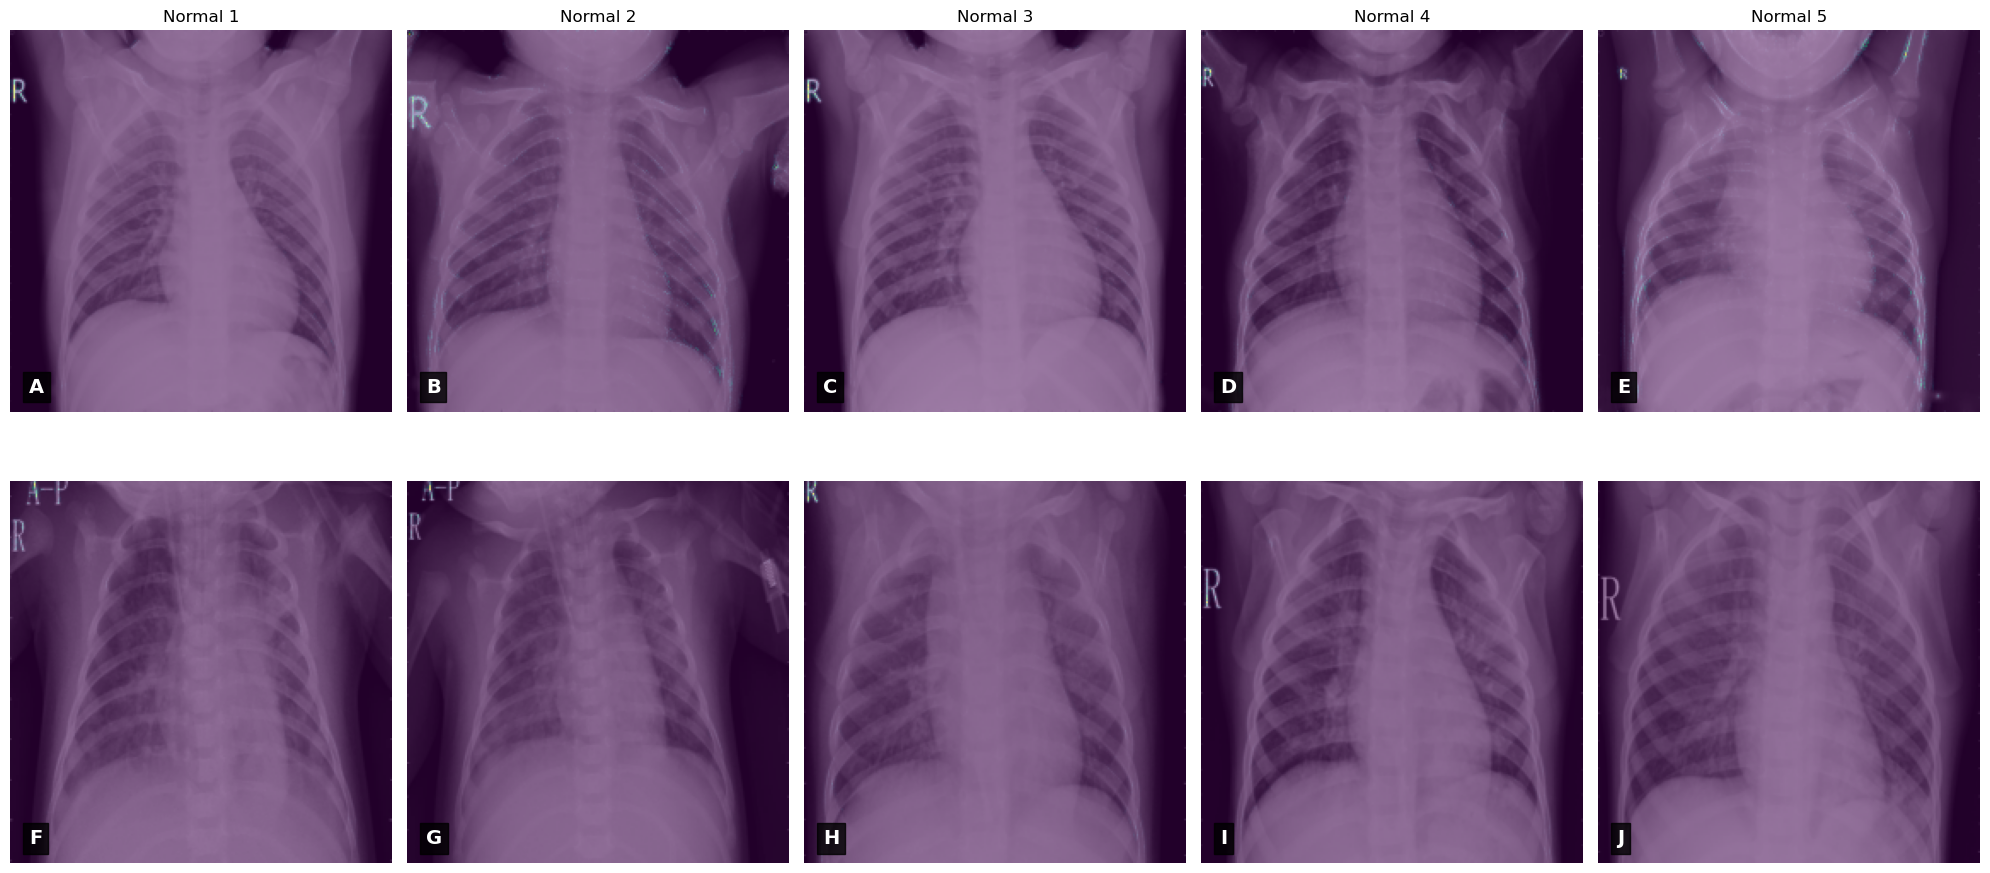

In [39]:
# Call the function for the second conv layer
visualize_ig_for_images(
    conv_layer_idx=1,                  # Second convolutional layer (index 1)
    models=[cnn_model],                # Use the trained model
    loader=val_loader,                 # Use validation data
    n=5,                               # Visualize 5 normal and 5 pneumonia images
    model_names=["Trained Model"]      # Custom model name
)


## Q4.1: GRAD CAM 2x5 -> Appendix

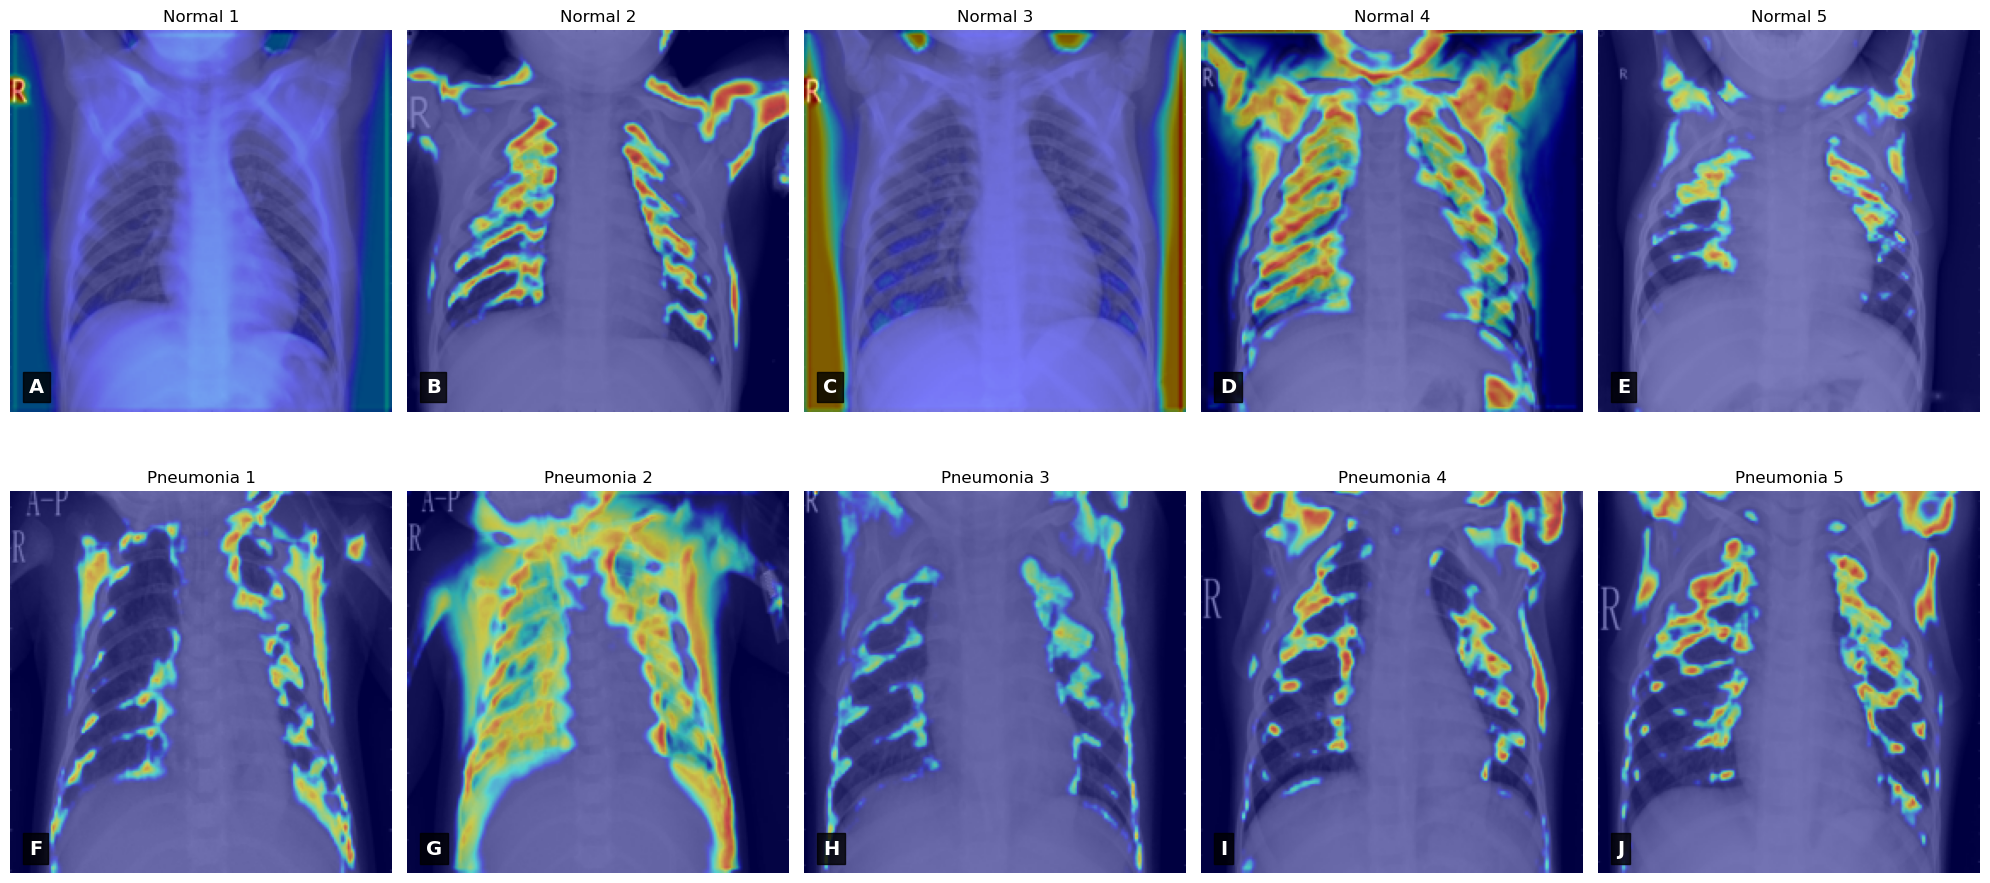

In [40]:

# Call the function for the second conv layer
visualize_gradcam_for_images(
    conv_layer_idx=1,                  # Second convolutional layer (index 1)
    models=[cnn_model], 
    loader=val_loader,                 # Use validation data
    n=5,                               # Visualize 5 normal and 5 pneumonia images
    model_names=["Trained Model"]        # Use the trained model
)

## Main Figure Part 2

In [41]:
# Check available convolutional layers
conv_layers = []
for name, layer in cnn_model.named_modules():
    if isinstance(layer, nn.Conv2d):
        conv_layers.append((name, layer))
print(f"Found {len(conv_layers)} convolutional layers:")
for i, (name, _) in enumerate(conv_layers):
    print(f"  {i}: {name}")

Found 2 convolutional layers:
  0: conv1
  1: conv2


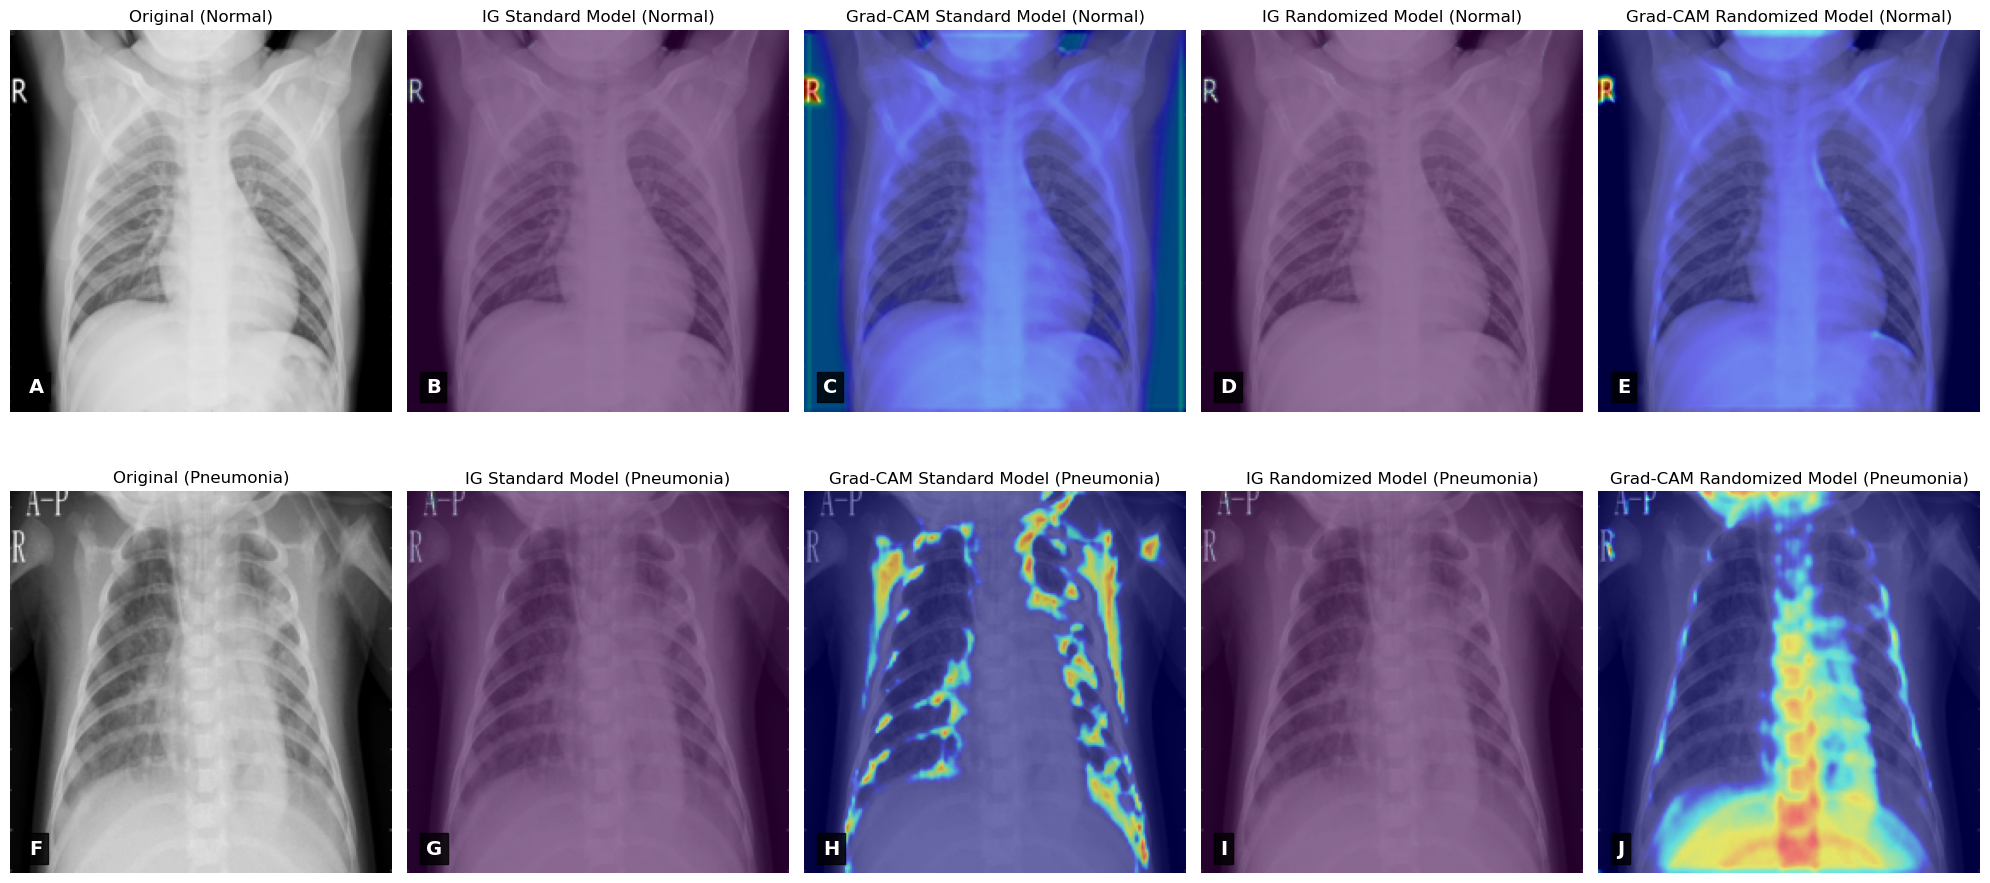


Target layers used:
Model 1: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Model 2: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [42]:
# Example usage of the new function with two models and layer index 1 (second conv layer)
result = visualize_comparisons(
    idx=0,                             # First sample
    conv_layer_idx=1,                  # Second convolutional layer (index 1)
    models=[cnn_model, cnn_model_random],  # Compare trained vs randomized model
    loader=val_loader,                 # Use validation data
    n=5,                               # Get 5 samples from each class
    model_names=["Standard Model", "Randomized Model"]  # Custom model names
)

print(f"\nTarget layers used:")
for i, layer in enumerate(result['target_layers']):
    print(f"Model {i+1}: {layer}")

## Layer Analysis -> Add-On, not necessarily included

Let's compare the attribution maps generated from different convolutional layers to see how the network's focus changes throughout the layers.

Comparing first conv layer (idx=0) with second conv layer (idx=1):


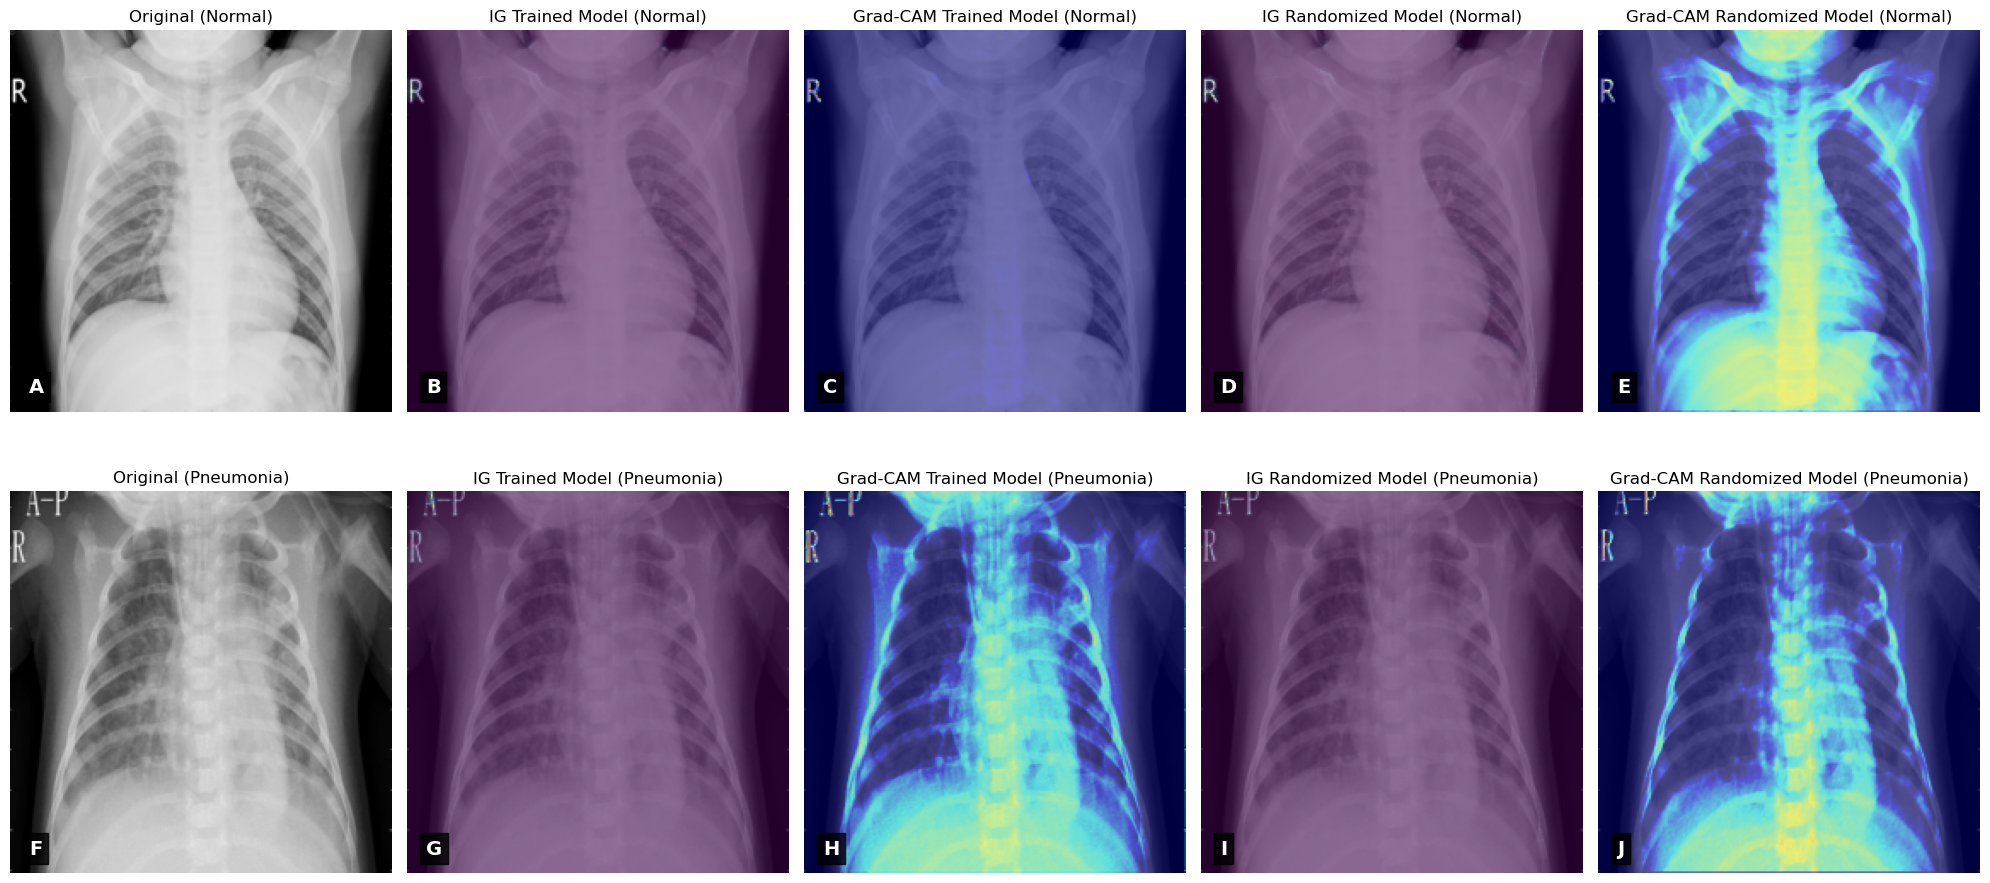

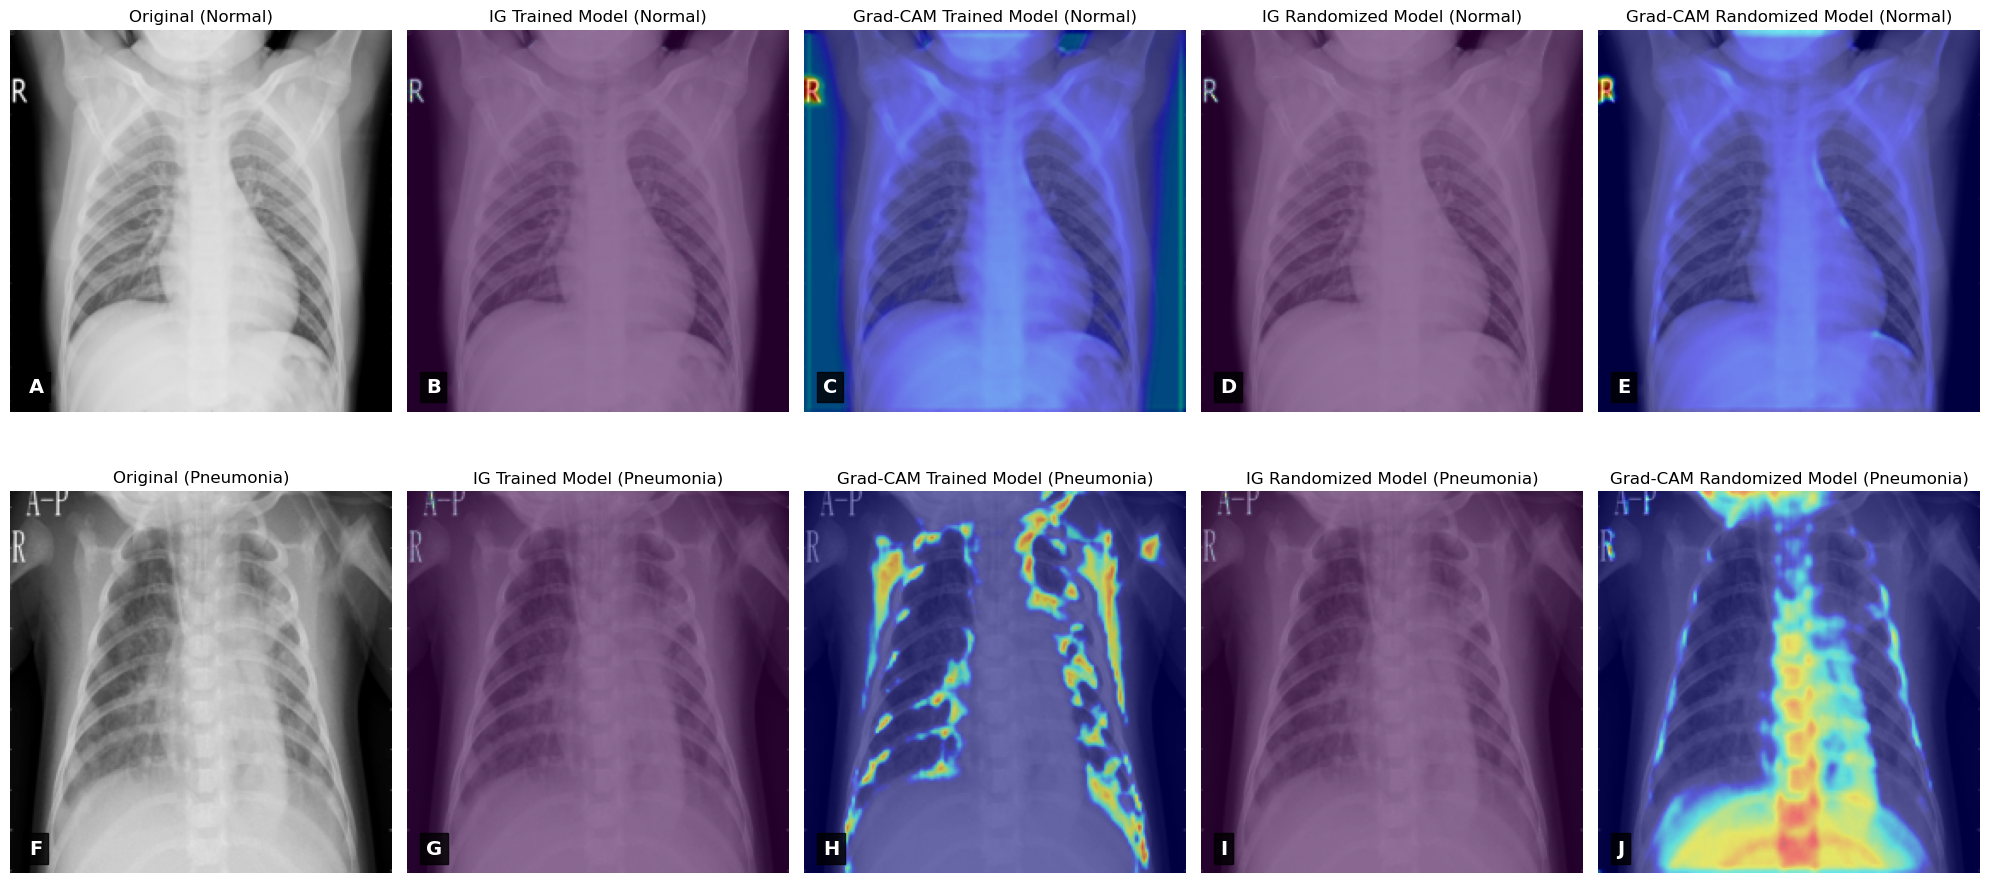

In [43]:
# Compare attributions from first and second conv layers
print("Comparing first conv layer (idx=0) with second conv layer (idx=1):")
result_conv1 = visualize_comparisons(
    idx=0,                             # First sample
    conv_layer_idx=0,                  # First convolutional layer
    models=[cnn_model, cnn_model_random],
    loader=val_loader,
    n=5,
    model_names=["Trained Model", "Randomized Model"]
)

result_conv2 = visualize_comparisons(
    idx=0,                             # Same sample
    conv_layer_idx=1,                  # Second convolutional layer
    models=[cnn_model, cnn_model_random],
    loader=val_loader,
    n=5,
    model_names=["Trained Model", "Randomized Model"]
)